In [0]:
a = []
while(1):
  a.append('1')

# Module Importing

In [1]:
!pip install catboost

In [0]:
# import os
# os.chdir('..')

In [0]:
import gc

In [0]:
import datetime

In [0]:
import holidays

In [0]:
import pandas as pd
import numpy as np

In [0]:
import re

In [0]:
import lightgbm as lgb
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [0]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
from itertools import product

In [0]:
from tqdm import tqdm_notebook

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
sns.set(style="darkgrid")

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [0]:
%matplotlib inline

# Data Loading

## Data fields
+ **ID** - an Id that represents a (Shop, Item) tuple within the test set
+ **shop_id** - unique identifier of a shop
+ **item_id** - unique identifier of a product
+ **item_category_id** - unique identifier of item category
+ **item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure
+ **item_price** - current price of an item
+ **date** - date in format dd/mm/yyyy
+ **date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
+ **item_name** - name of item
+ **shop_name** - name of shop
+ **item_category_name** - name of item category

## Sales_train
**(the training set. Daily historical data from January 2013 to October 2015)**

In [0]:
sales_train_df = pd.read_csv('sales_train.csv', parse_dates=['date'], 
                             dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                                    'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

In [19]:
sales_train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1
1,2013-03-01,0,25,2552,899.00,1
2,2013-05-01,0,25,2552,899.00,-1
3,2013-06-01,0,25,2554,1709.05,1
4,2013-01-15,0,25,2555,1099.00,1


In [20]:
print('Shape of sales_train.csv is (%d, %d)' % sales_train_df.shape)

Shape of sales_train.csv is (2935849, 6)


## Items
**(supplemental information about the items/products)**

In [0]:
items_df = pd.read_csv('items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})

In [22]:
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [23]:
print('Shape of items.csv is (%d, %d)' % items_df.shape)

Shape of items.csv is (22170, 3)


## Item_categories
**(supplemental information about the items categories)**

In [0]:
item_categories_df = pd.read_csv('item_categories.csv', dtype={'item_category_name': 'str', 'item_category_id': 'int32'})

In [25]:
item_categories_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [26]:
print('Shape of item_categories.csv is (%d, %d)' % item_categories_df.shape)

Shape of item_categories.csv is (84, 2)


## Shops
**(supplemental information about the shops)**

In [0]:
shops_df = pd.read_csv('shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})

In [28]:
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [29]:
print('Shape of shops.csv is (%d, %d)' % shops_df.shape)

Shape of shops.csv is (60, 2)


## test
**(the test set. You need to forecast the sales for these shops and products for November 2015)**

In [0]:
test_df = pd.read_csv('test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                              'item_id': 'int32'})

In [31]:
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [32]:
print('Shape of test.csv is (%d, %d)' % test_df.shape)

Shape of test.csv is (214200, 3)


# Basic EDA

In [0]:
def intitial_eda_checks(df: pd.DataFrame) -> None:
    """
        1. Take a dataframe.
        2. Check if there is duplicates.
        3. Check if there is nulls.
    """

    # keep=False - marke all duplicates as True
    if len(df[df.duplicated(keep=False)]) > 0:
        print('- Number of duplicates = {}'.format(len(df[df.duplicated(keep=False)])))
    else:
        print('- No duplicates found.')

    if df.isnull().sum().sum() > 0:
        mask_total = df.isnull().sum().sort_values(ascending=False) 
        total = mask_total[mask_total > 0]

        mask_percent = df.isnull().mean().sort_values(ascending=False) 
        percent = mask_percent[mask_percent > 0] 

        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
        print(f'- Total and Percentage of NaN:\n {missing_data}')
    else: 
        print('- No NaN found.')

### Descriptive statistics, number of missing values, etc

**First and last 5 rows of DataFrame:**

In [0]:
sales_train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [0]:
sales_train_df.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


**Basic information about a DataFrame:**

In [0]:
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [0]:
intitial_eda_checks(sales_train_df)

- Number of duplicates = 12
- No NaN found.


In [0]:
print('- Number of unique items = ',
      len(sales_train_df['item_id'].unique()))
print('- Number of unique items, which appears only once  = ',
      len(sales_train_df['item_id'].value_counts()[sales_train_df['item_id'].value_counts() == 1]))
print('- Number of unique items, which appears less or equal than 10 times  = ', 
      len(sales_train_df['item_id'].value_counts()[sales_train_df['item_id'].value_counts() < 10]))

- Number of unique items =  21807
- Number of unique items, which appears only once  =  2371
- Number of unique items, which appears less or equal than 10 times  =  6541


In [0]:
print('- Number of unique shops = ',
      len(sales_train_df['shop_id'].unique()))
print('- Number of unique shops, which appears only once  = ',
      len(sales_train_df['shop_id'].value_counts()[sales_train_df['shop_id'].value_counts() == 1]))
print('- Number of unique shops, which appears less or equal than 10000 times  = ', 
      len(sales_train_df['shop_id'].value_counts()[sales_train_df['shop_id'].value_counts() < 10000]))

- Number of unique shops =  60
- Number of unique shops, which appears only once  =  0
- Number of unique shops, which appears less or equal than 10000 times  =  12


In [0]:
len(sales_train_df['item_id'].value_counts()[sales_train_df['item_id'].value_counts() == 1])

2371

**Top-10 popular items:**

In [0]:
top_10_items = pd.DataFrame(sales_train_df.merge(items_df, left_on='item_id', right_on='item_id')['item_name'].value_counts()[:50]).reset_index()
top_10_items.columns = ['item_name', 'count']

In [0]:
top_10_items.head(10)

,item_name,count
0,Фирменный пакет майка 1С Интерес белый (34*42)...,31340
1,Playstation Store пополнение бумажника: Карта ...,9408
2,Прием денежных средств для 1С-Онлайн,9067
3,"Diablo III [PC, Jewel, русская версия]",7479
4,Kaspersky Internet Security Multi-Device Russi...,6853
5,World of Warcraft. Карта оплаты игрового време...,6602
6,"Grand Theft Auto V [PS3, русские субтитры]",6475
7,"Call of Duty: Black Ops II [PС, Jewel, русская...",6320
8,"Minecraft [Xbox 360, английская версия]",5811
9,"Grand Theft Auto V [Xbox 360, русские субтитры]",5805


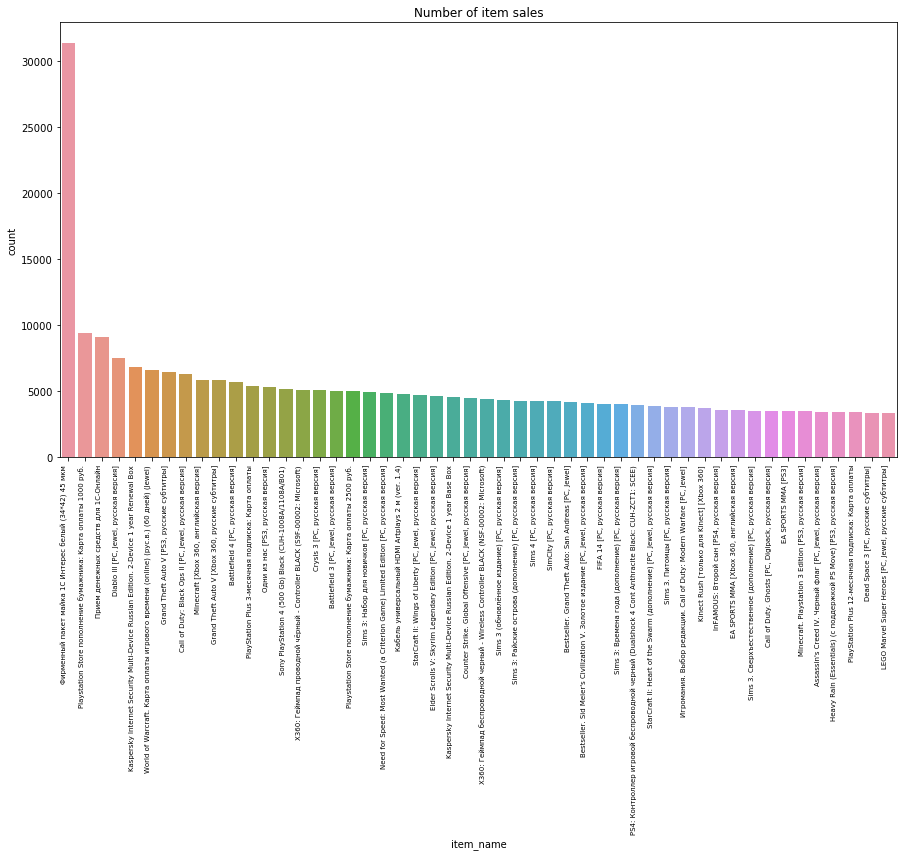

In [0]:
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
sns.barplot(x="item_name", y='count', data=top_10_items)
ax.set_title("Number of item sales");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=7);

In [0]:
del top_10_items

**Top-10 popular categories:**

In [0]:
top_10_categories = pd.DataFrame(sales_train_df.merge(items_df, left_on='item_id', right_on='item_id') \
                                               .merge(item_categories_df, left_on='item_category_id', right_on='item_category_id')['item_category_name'] \
                                               .value_counts() \
                                               .reset_index()[:50]
            )
top_10_categories.columns = ['caterory_name', 'count']

In [0]:
top_10_categories.head(10)

,caterory_name,count
0,Кино - DVD,564652
1,Игры PC - Стандартные издания,351591
2,Музыка - CD локального производства,339585
3,Игры - PS3,208219
4,Кино - Blu-Ray,192674
5,Игры - XBOX 360,146789
6,Игры PC - Дополнительные издания,121539
7,Игры - PS4,79058
8,Подарки - Мягкие игрушки,53845
9,Подарки - Настольные игры (компактные),53227


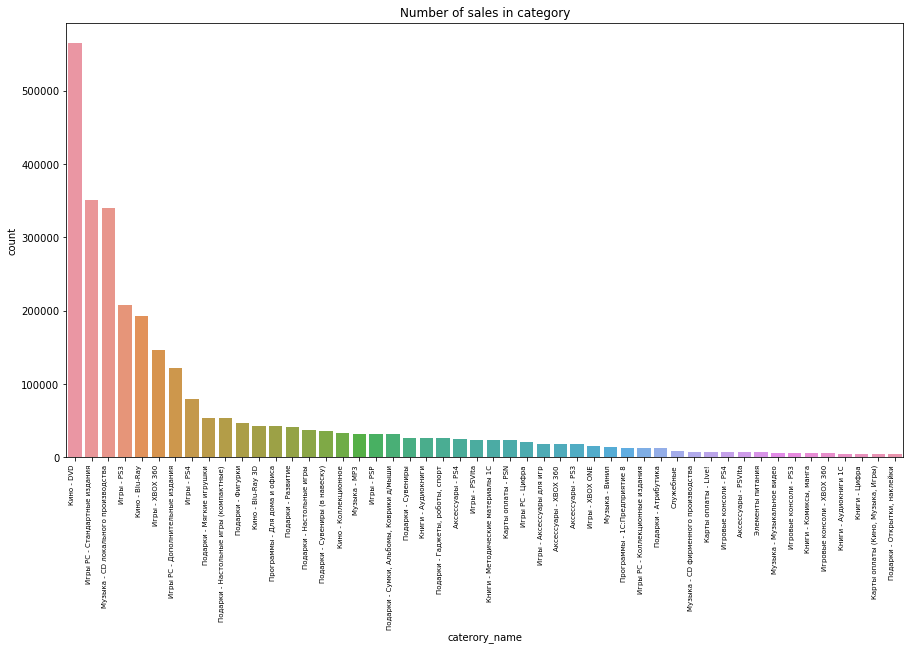

In [0]:
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
sns.barplot(x="caterory_name", y='count', data=top_10_categories)
ax.set_title("Number of sales in category");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=7);

In [0]:
del top_10_categories

**Top-10 popular shops:**

In [0]:
top_10_shops = pd.DataFrame(sales_train_df.merge(shops_df, left_on='shop_id', right_on='shop_id')['shop_name'] \
                                          .value_counts() \
                                          .reset_index()[:50])
top_10_shops.columns = ['shop_name', 'count']

In [0]:
top_10_shops.head(10)

,shop_name,count
0,"Москва ТЦ ""Семеновский""",235636
1,"Москва ТРК ""Атриум""",186104
2,"Химки ТЦ ""Мега""",143480
3,"Москва ТЦ ""МЕГА Теплый Стан"" II",142234
4,"Якутск Орджоникидзе, 56",117428
5,"СПб ТК ""Невский Центр""",109253
6,"Москва ТЦ ""МЕГА Белая Дача II""",105366
7,"Воронеж (Плехановская, 13)",82663
8,"Якутск ТЦ ""Центральный""",71441
9,"Чехов ТРЦ ""Карнавал""",69573


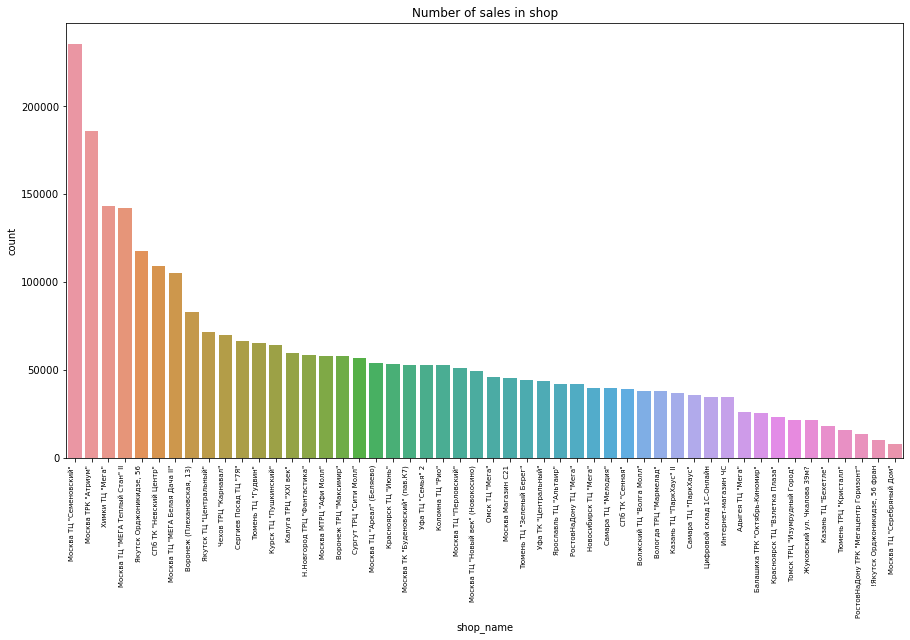

In [0]:
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
sns.barplot(x="shop_name", y='count', data=top_10_shops)
ax.set_title("Number of sales in shop");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=7);

In [0]:
del top_10_shops

**Monthly and daily sales:**

In [0]:
sales = sales_train_df.copy()

In [0]:
def revers_date(x: str):
    buf = x.split('.')
    return '.'.join([buf[2], buf[1], buf[0]])

In [0]:
sales['date'] = sales['date'].apply(revers_date)

In [0]:
sales.date.values.sort()

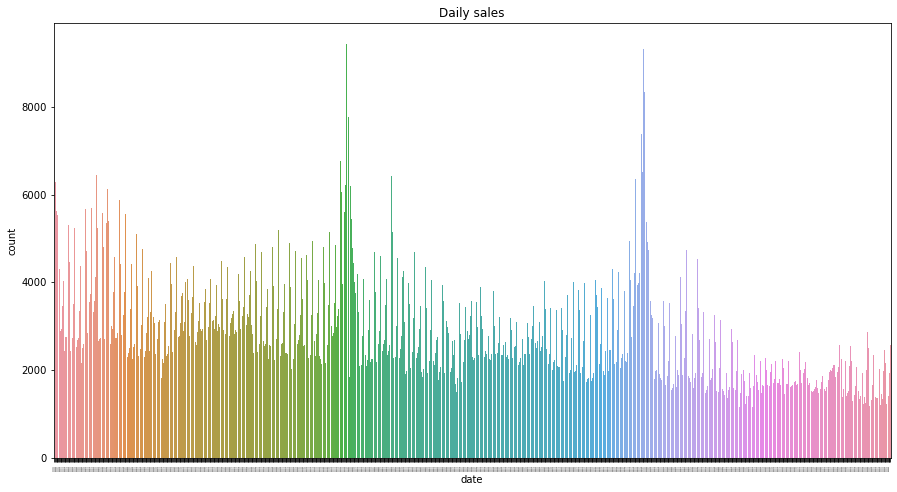

In [0]:
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
sns.countplot(x="date", data=sales, ax=ax)
ax.set_title("Daily sales");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=0);

In [0]:
sales['date'] = sales['date'].apply(lambda x: x[:-3])

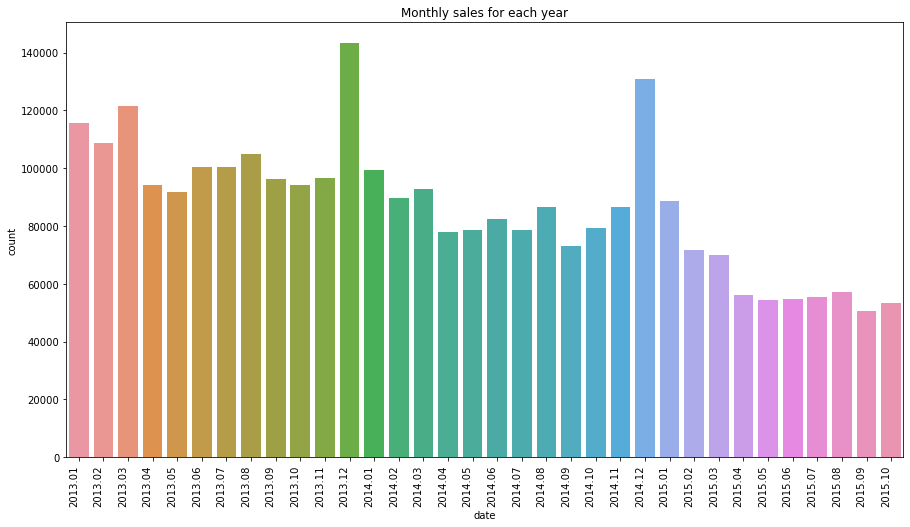

In [0]:
fig, ax = plt.subplots(1, 1, figsize = (15,8))
sns.countplot(x="date", data=sales, ax=ax)
ax.set_title("Monthly sales for each year");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right");

In [0]:
sales['date'] = sales['date'].apply(lambda x: x[-2:])

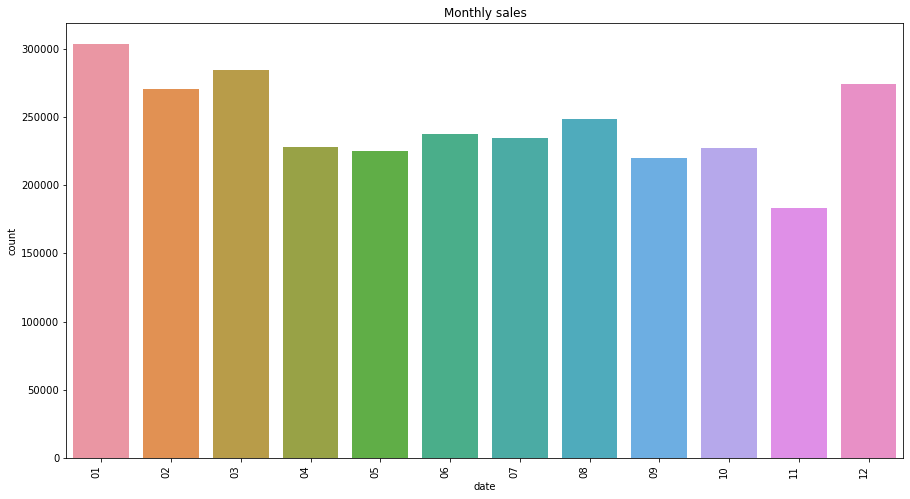

In [0]:
fig, ax = plt.subplots(1, 1, figsize = (15,8))
sns.countplot(x="date", data=sales, ax=ax)
ax.set_title("Monthly sales");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right");

In [0]:
del sales

**How sales behaves along the year?**

In [0]:
monthly_sales = sales_train_df.copy()

In [0]:
monthly_sales = monthly_sales.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)

In [0]:
monthly_sales = monthly_sales.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})

In [0]:
monthly_sales.columns = ['date_block_num', 'shop_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [0]:
monthly_sales['year'] = monthly_sales['date_block_num'].apply(lambda x: ((x//12) + 2013))
monthly_sales['month'] = monthly_sales['date_block_num'].apply(lambda x: (x % 12))

In [0]:
monthly_sales.head()

,date_block_num,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,0,32,884.0,221.0,6.0,1.5,4
1,0,0,33,1041.0,347.0,3.0,1.0,3
2,0,0,35,247.0,247.0,1.0,1.0,1
3,0,0,43,221.0,221.0,1.0,1.0,1
4,0,0,51,257.0,128.5,2.0,1.0,2


In [0]:
gp_month_mean = monthly_sales.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = monthly_sales.groupby(['month'], as_index=False)['item_cnt'].sum()

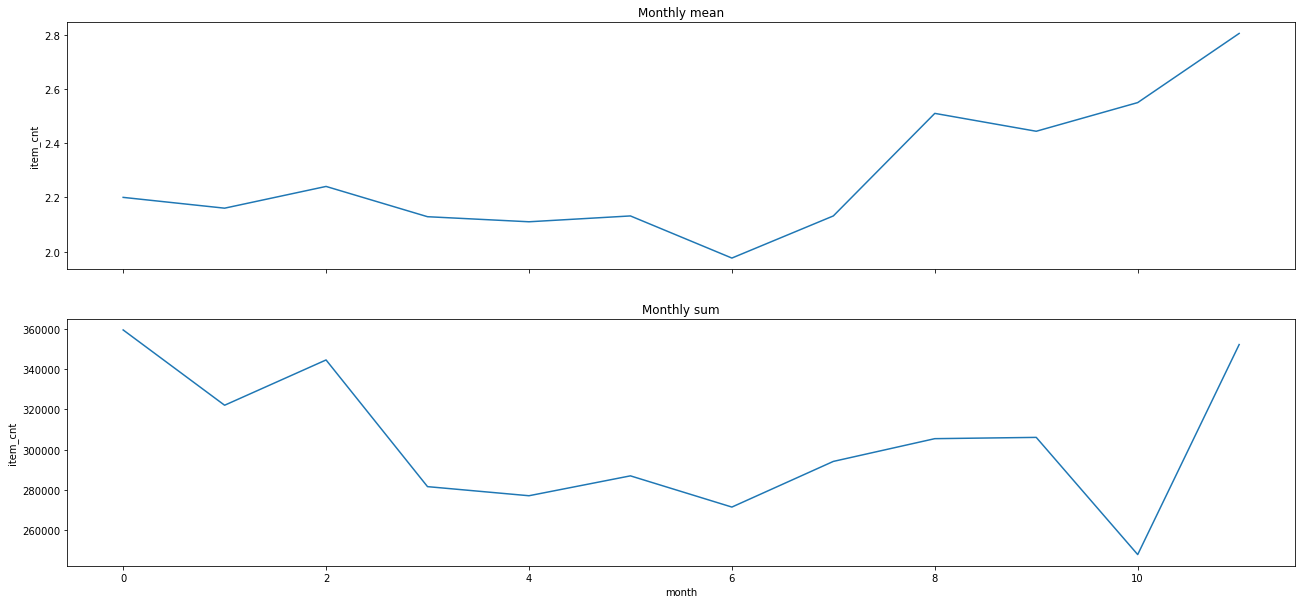

In [0]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

In [0]:
del gp_month_mean, gp_month_sum

**What shop sells more?**

In [0]:
gp_shop_mean = monthly_sales.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = monthly_sales.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

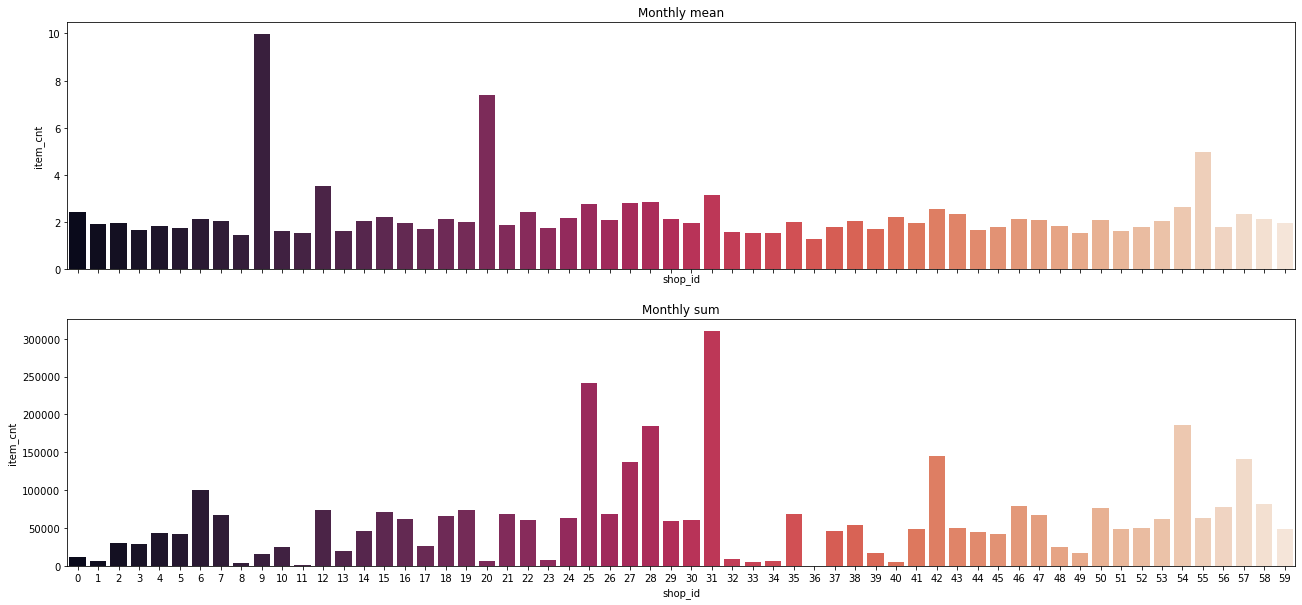

In [0]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

In [0]:
del gp_shop_mean, gp_shop_sum

**Checking for outliers:**

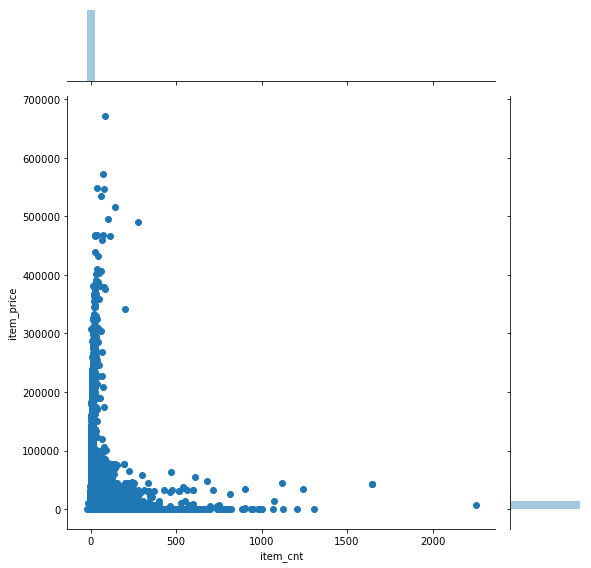

In [0]:
sns.jointplot(x="item_cnt", y="item_price", data=monthly_sales, height=8)

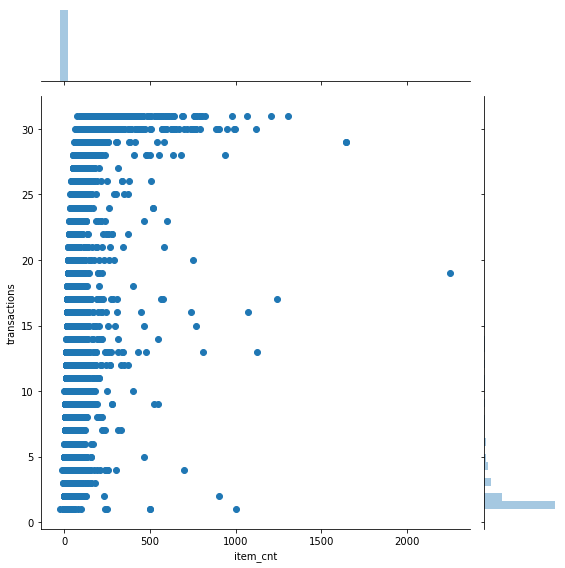

In [0]:
sns.jointplot(x="item_cnt", y="transactions", data=monthly_sales, height=8)

**Feature "item_cnt" distribution:**

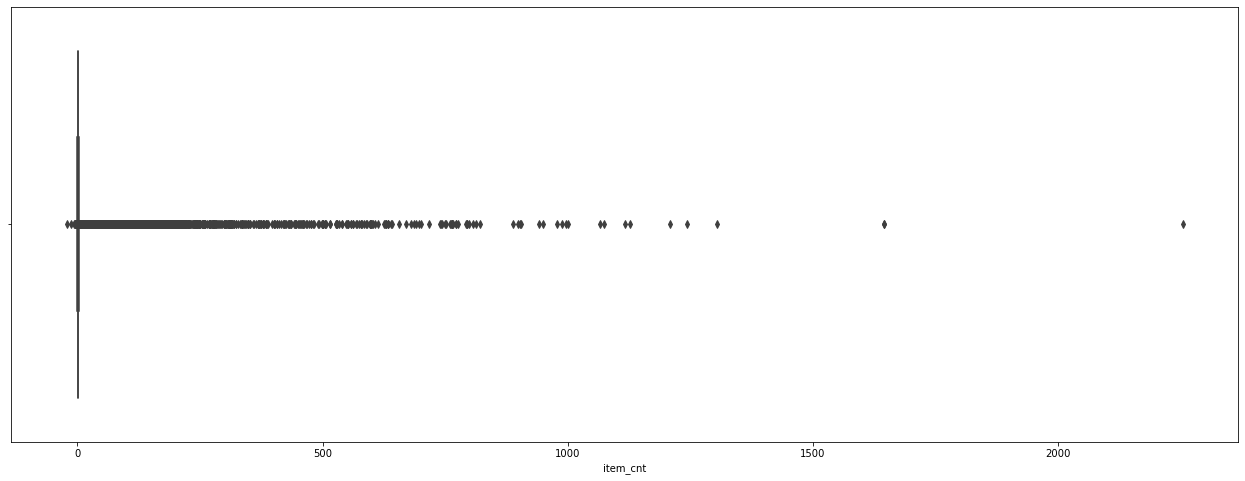

In [0]:
plt.subplots(figsize=(22, 8))
sns.boxplot(monthly_sales['item_cnt'])
plt.show()

In [0]:
del monthly_sales

**Number of item sales per month for each shop:**

In [0]:
grouped = pd.DataFrame(sales_train_df.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())

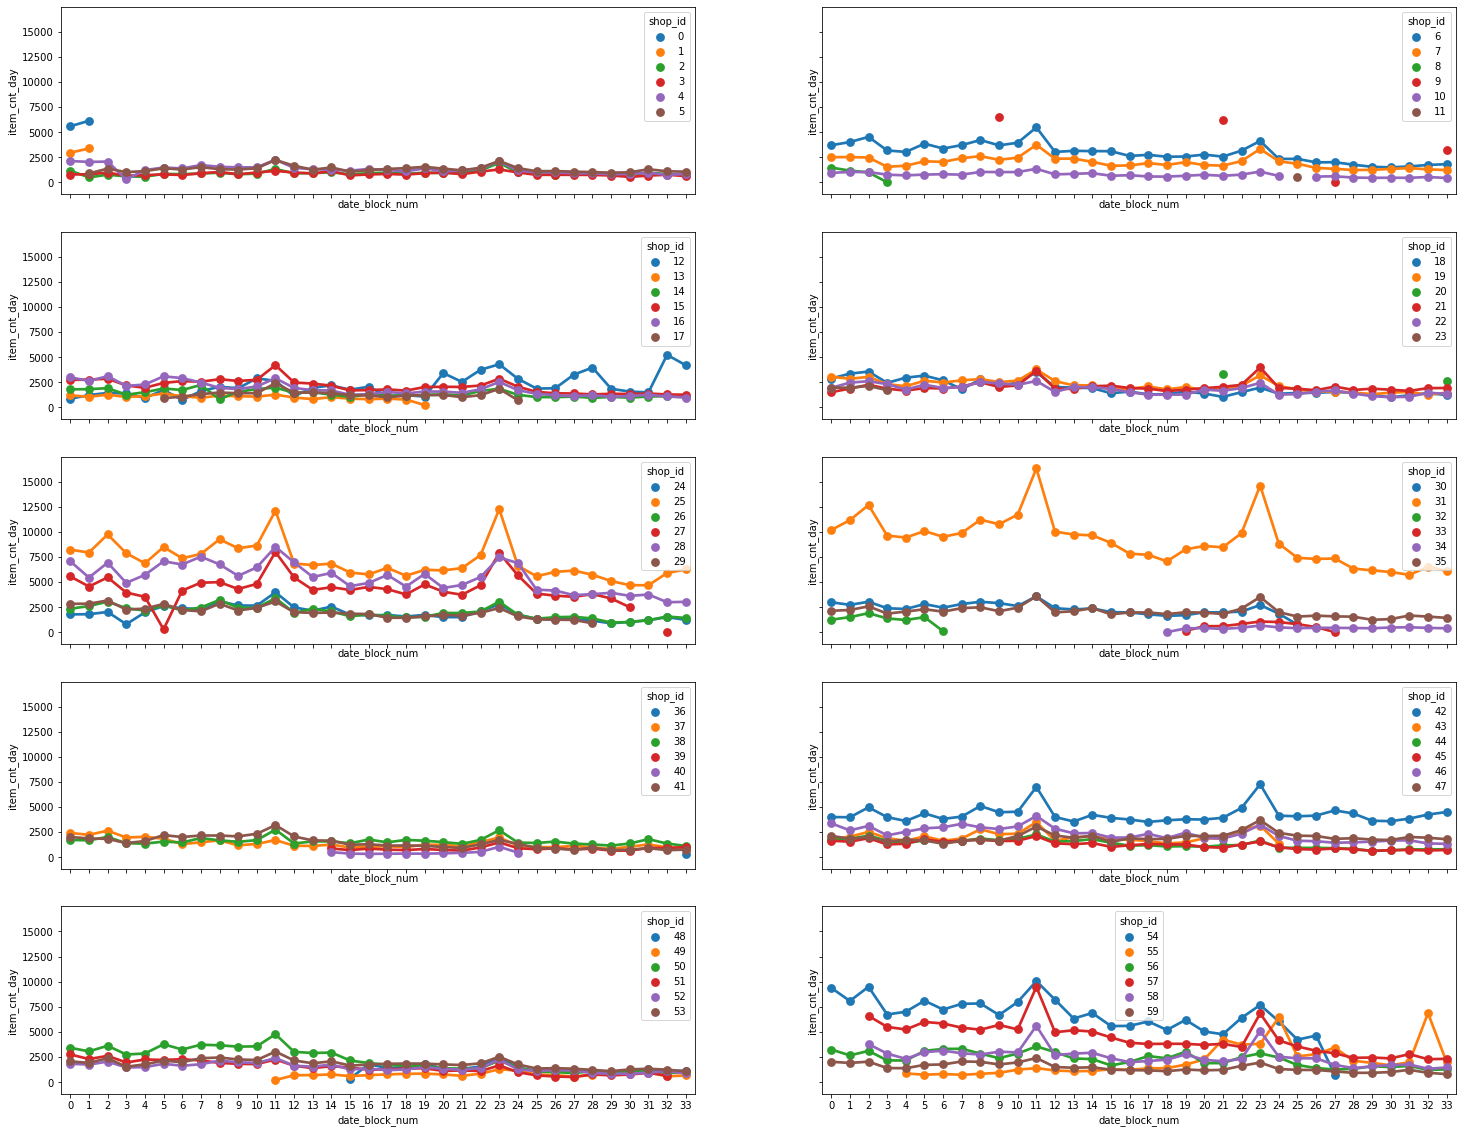

In [0]:
num_graph = 10
count = 0

fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(25,20))
id_per_graph = np.ceil(grouped.shop_id.max() / num_graph)

for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id',
                      data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)],
                      ax=axes[i][j])
        count += 1

In [0]:
del grouped

In [0]:
gc.collect()

30

# Basic data preparation

In [0]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

### Adding revenue column

In [0]:
sales_train_df['revenue'] = sales_train_df['item_price'] * sales_train_df['item_cnt_day']

In [0]:
# sales_train_df.head()

### Join datasets

In [0]:
# train = sales_train_df.join(items_df, on='item_id', rsuffix='_') \
#                       .join(shops_df, on='shop_id', rsuffix='_') \
#                       .join(item_categories_df, on='item_category_id', rsuffix='_') \
#                       .drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

### Time period of the dataset

In [37]:
print('Min date from train set: %s' % sales_train_df['date'].min().date())
print('Max date from train set: %s' % sales_train_df['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


### Extract month and year from 'date_block_num'

In [0]:
sales_train_df['year'] = sales_train_df['date_block_num'].apply(lambda x: ((x//12) + 2013))
sales_train_df['month'] = sales_train_df['date_block_num'].apply(lambda x: (x % 12))

### Date column to correct format

In [0]:
# sales_train_df['date'] = sales_train_df['date'].apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))

### Adding information about category

In [0]:
sales_train_df = sales_train_df.join(items_df, on='item_id', rsuffix='_').drop(['item_id_', 'item_name'], axis=1)

### Dropping duplicates

In [0]:
subset = ['date','date_block_num','shop_id','item_id','item_cnt_day']

In [42]:
print('Duplicates: {}'.format(sales_train_df.duplicated(subset=subset).sum()))

Duplicates: 24


In [0]:
sales_train_df.drop_duplicates(subset=subset, inplace=True)

### Dropping negative price

In [0]:
sales_train_df = sales_train_df.query('item_price > 0')

### Data leakages. Dropping shops and items not in test data

In [0]:
test_shops = test_df.shop_id.unique()
test_items = test_df.item_id.unique()

In [0]:
train = sales_train_df[sales_train_df.shop_id.isin(test_shops)]
train = sales_train_df[sales_train_df.item_id.isin(test_items)]

In [0]:
del test_shops, test_items

In [48]:
gc.collect()

20

### Creating all combinations

In [0]:
# Group by month in this case "date_block_num" and aggregate features.
train_monthly = sales_train_df.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False) \
                              .agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})

# Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [0]:
# Build a data set with all the possible combinations of ['date_block_num','shop_id','item_id'] so we won't have missing records.
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [0]:
# Merge the train set with the complete set (missing records will be filled with 0).
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)

In [52]:
del empty_df
gc.collect()

0

### Adding month and year columns

In [0]:
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

### Removing outliers

In [0]:
# train_month['item_cnt'].clip(0, 20, inplace=True)

In [0]:
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 400000')

### Creating target label

In [0]:
# try without shift

In [0]:
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(0)

# Feature creation

### Unitary item prices.

In [0]:
train_monthly['item_price_unit'] = train_monthly['item_price'] // train_monthly['item_cnt']
train_monthly['item_price_unit'].fillna(0, inplace=True)

### Historical min/max price

In [0]:
gp_item_price = sales_train_df.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')

In [0]:
train_monthly['price_increase'] = train_monthly['item_price'] - train_monthly['hist_min_item_price']
train_monthly['price_decrease'] = train_monthly['hist_max_item_price'] - train_monthly['item_price']
train_monthly['price_diff'] = train_monthly['hist_max_item_price'] - train_monthly['hist_min_item_price']

In [61]:
del gp_item_price
gc.collect()

13

### Min, max, mean shop revenue


In [0]:
gp_revenue_shop = sales_train_df.sort_values('date_block_num').groupby(['shop_id'], as_index=False).agg({'revenue':[np.min, np.max, np.mean]})
gp_revenue_shop.columns = ['shop_id', 'hist_min_shop_revenue', 'hist_max_shop_revenue', 'hist_mean_shop_revenue']

In [0]:
train_monthly = pd.merge(train_monthly, gp_revenue_shop, on='shop_id', how='left')

In [0]:
del gp_revenue_shop
gc.collect()

0

### Min, max, mean shop revenue for each month

In [0]:
gp_revenue_shop_month = sales_train_df.sort_values('date_block_num').groupby(['shop_id', 'month'], as_index=False).agg({'revenue':[np.min, np.max, np.mean]})
gp_revenue_shop_month.columns = ['shop_id', 'month', 'hist_min_shop_revenue_month', 'hist_max_shop_revenue_month', 'hist_mean_shop_revenue_month']

In [0]:
train_monthly = pd.merge(train_monthly, gp_revenue_shop_month, on=['shop_id', 'month'], how='left')

In [0]:
del gp_revenue_shop_month
gc.collect()

0

### Min, max, mean item_category revenue

In [0]:
gp_revenue_category = sales_train_df.sort_values('date_block_num').groupby(['item_category_id'], as_index=False).agg({'revenue':[np.min, np.max, np.mean]})
gp_revenue_category.columns = ['item_category_id', 'hist_min_category_revenue', 'hist_max_category_revenue', 'hist_mean_category_revenue']

In [0]:
train_monthly = pd.merge(train_monthly, gp_revenue_category, on='item_category_id', how='left')

In [0]:
del gp_revenue_category
gc.collect()

0

### Min, max, mean item_category revenue for each month

In [0]:
gp_revenue_category_month = sales_train_df.sort_values('date_block_num').groupby(['item_category_id', 'month'], as_index=False).agg({'revenue':[np.min, np.max, np.mean]})
gp_revenue_category_month.columns = ['item_category_id', 'month', 'hist_min_category_revenue_month', 'hist_max_category_revenue_month', 'hist_mean_category_revenue_month']

In [0]:
train_monthly = pd.merge(train_monthly, gp_revenue_category_month, on=['item_category_id', 'month'], how='left')

In [0]:
del gp_revenue_category_month
gc.collect()

0

### Min, max, mean item_category revenue for each shop

In [0]:
gp_revenue_category_shop = sales_train_df.sort_values('date_block_num').groupby(['item_category_id', 'shop_id'], as_index=False).agg({'revenue':[np.min, np.max, np.mean]})
gp_revenue_category_shop.columns = ['item_category_id', 'shop_id', 'hist_min_category_revenue_shop',
                                    'hist_max_category_revenue_month_shop', 'hist_mean_category_revenue_month_shop']

In [0]:
train_monthly = pd.merge(train_monthly, gp_revenue_category_shop, on=['item_category_id', 'shop_id'], how='left')

In [0]:
del gp_revenue_category_shop
gc.collect()

0

### Min, max, mean item_category revenue for each shop and month

In [0]:
gp_revenue_category_shop_month = sales_train_df.sort_values('date_block_num').groupby(['item_category_id', 'shop_id', 'month'], as_index=False).agg({'revenue':[np.min, np.max, np.mean]})
gp_revenue_category_shop_month.columns = ['item_category_id', 'shop_id', 'month', 'hist_min_category_revenue_shop_month',
                                    'hist_max_category_revenue_month_shop_month', 'hist_mean_category_revenue_month_shop_month']

In [0]:
train_monthly = pd.merge(train_monthly, gp_revenue_category_shop_month, on=['item_category_id', 'shop_id', 'month'], how='left')

In [0]:
del gp_revenue_category_shop_month
gc.collect()

0

### Holiday feature

In [0]:
train_monthly['holiday_ft'] = train_monthly.month.map({0: 1, 1: 0, 2: 1, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 10:0, 11:1})

### Downcast dtypes

In [0]:
import sys

In [80]:
sys.getsizeof(train_monthly) / (1024)**3

7.952553413808346

In [0]:
train_monthly = downcast_dtypes(train_monthly)

### Rolling windows based features

In [0]:
gp = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt']

In [75]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()

function_list = [f_min, f_max]
function_name = ['min', 'max']

for i in tqdm_notebook(range(len(function_list))):
    train_monthly[('item_cnt_%s' % function_name[i])] = gp.apply(function_list[i]).astype(np.float32)

In [76]:
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_mean, f_std]
function_name = ['mean', 'std']

for i in tqdm_notebook(range(len(function_list))):
    train_monthly[('item_cnt_%s' % function_name[i])] = gp.apply(function_list[i]).astype(np.float32)

# Fill the empty std features with 0
train_monthly['item_cnt_std'].fillna(0, inplace=True)

In [77]:
del gp
gc.collect()

3

#### Lags features

In [0]:
# check name for lag and trend feature

In [0]:
lag_list = [1, 2, 3, 4, 5, 6, 12]

In [66]:
gp = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt']
for lag in tqdm_notebook(lag_list):
    ft_name = ('item_cnt_shifted_1_%s' % lag)
    train_monthly[ft_name] = gp.shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

In [68]:
gp = train_monthly.sort_values('date_block_num').groupby(['shop_id'])['item_cnt']
for lag in tqdm_notebook(lag_list):
    ft_name = ('item_cnt_shifted_2_%s' % lag)
    train_monthly[ft_name] = gp.shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

In [69]:
gp = train_monthly.sort_values('date_block_num').groupby(['item_id'])['item_cnt']
for lag in tqdm_notebook(lag_list):
    ft_name = ('item_cnt_shifted_3_%s' % lag)
    train_monthly[ft_name] = gp.shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

In [67]:
gp = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'month'])['item_cnt']
for lag in tqdm_notebook(lag_list):
    ft_name = ('item_cnt_shifted_4_%s' % lag)
    train_monthly[ft_name] = gp.shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

In [68]:
gp = train_monthly.sort_values('date_block_num').groupby(['item_id', 'month'])['item_cnt']
for lag in tqdm_notebook(lag_list):
    ft_name = ('item_cnt_shifted_5_%s' % lag)
    train_monthly[ft_name] = gp.shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

In [0]:
del gp
gc.collect()

### Trend feature

In [0]:
train_monthly['item_trend_1'] = train_monthly['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted_1_%s' % lag)
    train_monthly['item_trend_1'] -= train_monthly[ft_name]

train_monthly['item_trend_1'] /= len(lag_list) + 1

In [0]:
train_monthly['item_trend_2'] = train_monthly['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted_2_%s' % lag)
    train_monthly['item_trend_2'] -= train_monthly[ft_name]

train_monthly['item_trend_2'] /= len(lag_list) + 1

In [0]:
train_monthly['item_trend_3'] = train_monthly['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted_3_%s' % lag)
    train_monthly['item_trend_3'] -= train_monthly[ft_name]

train_monthly['item_trend_3'] /= len(lag_list) + 1

In [0]:
train_monthly['item_trend_4'] = train_monthly['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted_4_%s' % lag)
    train_monthly['item_trend_4'] -= train_monthly[ft_name]

train_monthly['item_trend_4'] /= len(lag_list) + 1

In [0]:
train_monthly['item_trend_5'] = train_monthly['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted_5_%s' % lag)
    train_monthly['item_trend_5'] -= train_monthly[ft_name]

train_monthly['item_trend_5'] /= len(lag_list) + 1

### Text feature creation

In [81]:
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [82]:
shops_df.loc[shops_df.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

shops_df['city'] = shops_df['shop_name'].str.split(' ').map(lambda x: x[0])
shops_df['category'] = shops_df['shop_name'].str.split(' ').map(lambda x:x[1]).astype(str)

shops_df.loc[shops_df.city == '!Якутск', 'city'] = 'Якутск'

category = ['Орджоникидзе,', 'ТЦ', 'ТРК', 'ТРЦ','ул.', 'Магазин', 'ТК', 'склад']
shops_df.category = shops_df.category.apply(lambda x: x if (x in category) else 'etc')
shops_df.category.unique()

array(['Орджоникидзе,', 'ТЦ', 'ТРК', 'ТРЦ', 'etc', 'ул.', 'Магазин', 'ТК',
       'склад'], dtype=object)

In [83]:
category = ['ТЦ', 'ТРК', 'ТРЦ', 'ТК']
shops_df.category = shops_df.category.apply(lambda x: x if (x in category) else 'etc')
print('Category Distribution', shops_df.groupby(['category']).sum())

Category Distribution           shop_id
category         
etc           223
ТК            184
ТРК           140
ТРЦ           340
ТЦ            883


In [84]:
shops_df['shop_city'] = shops_df.city
shops_df['shop_category'] = shops_df.category

shops_df['shop_city'] = LabelEncoder().fit_transform(shops_df['shop_city'])
shops_df['shop_category'] = LabelEncoder().fit_transform(shops_df['shop_category'])

shops_df = shops_df[['shop_id','shop_city', 'shop_category']]
shops_df.head()

,shop_id,shop_city,shop_category
0,0,29,0
1,1,29,4
2,2,0,4
3,3,1,2
4,4,2,4


In [85]:
item_categories_df['type_code'] = item_categories_df.item_category_name.apply(lambda x: x.split(' ')[0]).astype(str)
item_categories_df.loc[(item_categories_df.type_code == 'Игровые') | (item_categories_df.type_code == 'Аксессуары'), 'category'] = 'Игры'
item_categories_df.loc[item_categories_df.type_code == 'PC', 'category'] = 'Музыка'

category = ['Игры', 'Карты', 'Кино', 'Книги','Музыка', 'Подарки', 'Программы', 'Служебные', 'Чистые']

item_categories_df['type_code'] = item_categories_df.type_code.apply(lambda x: x if (x in category) else 'etc')

print(item_categories_df.groupby(['type_code']).sum())
item_categories_df['type_code'] = LabelEncoder().fit_transform(item_categories_df['type_code'])

item_categories_df['split'] = item_categories_df.item_category_name.apply(lambda x: x.split('-'))
item_categories_df['subtype'] = item_categories_df['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories_df['subtype_code'] = LabelEncoder().fit_transform(item_categories_df['subtype'])
item_categories_df = item_categories_df[['item_category_id','type_code', 'subtype_code']]

           item_category_id
type_code                  
etc                     236
Игры                    343
Карты                   170
Кино                    195
Книги                   624
Музыка                  345
Подарки                 798
Программы               453
Служебные               159
Чистые                  163


In [86]:
item_categories_df.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,0,9
2,2,0,10
3,3,0,11
4,4,0,13


In [87]:
from collections import Counter
from operator import itemgetter

items_df['name_1'], items_df['name_2'] = items_df['item_name'].str.split('[', 1).str
items_df['name_1'], items_df['name_3'] = items_df['item_name'].str.split('(', 1).str

items_df['name_2'] = items_df['name_2'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items_df['name_3'] = items_df['name_3'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items_df = items_df.fillna('0')

result_1 = Counter(' '.join(items_df['name_2'].values.tolist()).split(' ')).items()
result_1 = sorted(result_1, key=itemgetter(1))
result_1 = pd.DataFrame(result_1, columns=['feature', 'count'])
result_1 = result_1[(result_1['feature'].str.len() > 1) & (result_1['count'] > 200)]

result_2 = Counter(' '.join(items_df['name_3'].values.tolist()).split(" ")).items()
result_2 = sorted(result_2, key=itemgetter(1))
result_2 = pd.DataFrame(result_2, columns=['feature', 'count'])
result_2 = result_2[(result_2['feature'].str.len() > 1) & (result_2['count'] > 200)]

result = pd.concat([result_1, result_2])
result = result.drop_duplicates(subset=['feature']).reset_index(drop=True)

print('Most common aditional features:', result)

def name_correction(x):
    x = x.lower()
    x = x.partition('[')[0]
    x = x.partition('(')[0]
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x)
    x = x.replace('  ', ' ')
    x = x.strip()
    return x

items_df['item_name'] = items_df['item_name'].apply(lambda x: name_correction(x))
items_df.name_2 = items_df.name_2.apply(lambda x: x[:-1] if x != '0' else '0')

Most common aditional features:          feature  count
0   документация    284
1     английская    340
2        русские    399
3       субтитры    400
4            360    465
5          jewel    552
6           xbox    589
7            ps3    611
8        русская   1428
9       цифровая   1995
10            pc   2585
11        версия   3427
12           box    246
13            3d    409
14           dvd    503
15      digipack    541
16          фирм    757
17           mp3    854
18            cd    871
19        регион   1849
20            bd   2320


In [88]:
items_df['type'] = items_df.name_2.apply(lambda x: x[0:8] if x.split(' ')[0] == 'xbox' else x.split(' ')[0])
items_df.loc[(items_df.type == 'x360') | (items_df.type == 'xbox360'), 'type'] = 'xbox 360'
items_df.loc[items_df.type == '', 'type'] = 'mac'
items_df.type = items_df.type.apply(lambda x: x.replace(' ',''))
items_df.loc[(items_df.type == 'pc') | (items_df.type == 'pс') | (items_df.type == 'рс'), 'type'] = 'pc'
items_df.loc[(items_df.type == 'рs3'), 'type'] = 'ps3'

group_sum = items_df.groupby('type').sum()
group_sum.loc[group_sum.item_category_id < 200]

,item_id,item_category_id
type,,
5c5,12118,16
5c7,26808,32
5f4,7936,7
6dv,7934,7
6jv,7924,7
6l6,7935,7
android,12994,78
hm3,7926,7
j72,31709,28


In [89]:
drop_list = ['5c5', '5c7', '5f4', '6dv', '6jv', '6l6', 'android', 'hm3', 'j72', 'kf6', 'kf7','kg4',
            'ps2', 's3v', 's4v'	,'англ', 'русская', 'только', 'цифро']

items_df.name_2 = items_df.type.apply(lambda x: 'etc' if x in drop_list else x)
items_df = items_df.drop(['type'], axis=1)
items_df.groupby('name_2').sum()

,item_id,item_category_id
name_2,,
0,218310960,872182
etc,253458,550
mac,148743,2323
pc,16991083,106924
ps,431537,1738
ps3,3531772,11422
ps4,895981,3489
psp,692947,2415
xbox360,2362398,10718


In [90]:
items_df['name_2'] = LabelEncoder().fit_transform(items_df['name_2'])
items_df['name_3'] = LabelEncoder().fit_transform(items_df['name_3'])
items_df.drop(['item_name', 'name_1'], axis=1, inplace=True)
items_df.head()

,item_id,item_category_id,name_2,name_3
0,0,40,0,1331
1,1,76,3,42
2,2,40,0,1011
3,3,40,0,1010
4,4,40,0,1572


In [0]:
train_monthly = train_monthly.merge(shops_df, on=['shop_id'])

In [0]:
train_monthly = train_monthly.merge(item_categories_df, on=['item_category_id'])

In [0]:
train_monthly = train_monthly.merge(items_df, on=['item_id', 'item_category_id'])

# Train/test split

In [94]:
train_set = train_monthly.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = train_monthly.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = train_monthly.query('date_block_num == 33').copy()

train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/train_monthly.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/train_monthly.shape[0])*100)))

Train set records: 1224382
Validation set records: 160791
Test set records: 31462
Train set records: 1224382 (76% of complete data)
Validation set records: 160791 (10% of complete data)


In [95]:
del train_monthly
gc.collect()

92

# Mean encoding (Smoothing)

In [0]:
def calc_smooth_mean(df, by, on, m):
    mean = df[on].mean()
    
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']
    
    smooth = (counts * means + m * mean) / (counts + m)
    
    return smooth

In [0]:
mean_enc_item_cat = pd.DataFrame(train_set.groupby(['shop_id', 
                                                    'item_category_id']).item_cnt_month.agg(['mean', 'var']).reset_index())
mean_enc_item_cat.columns = ['shop_id', 'item_category_id', 'mean_enc_cat_id', 'var_enc_cat_id']

In [0]:
mean_enc_shop_id = pd.DataFrame(train_set.groupby(['shop_id']).item_cnt_month.agg(['mean', 'var']).reset_index())
mean_enc_shop_id.columns = ['shop_id', 'mean_enc_shop_id', 'var_enc_shop_id']

In [0]:
mean_enc_shop_month = pd.DataFrame(train_set.groupby(['shop_id', 'month']).item_cnt_month.agg(['mean', 'var']).reset_index())
mean_enc_shop_month.columns = ['shop_id', 'month', 'mean_enc_shop_month', 'var_enc_shop_month']

In [0]:
global_mean = train_set["item_cnt_month"].mean()

In [0]:
gp_shop_mean = pd.DataFrame(calc_smooth_mean(train_set, 'shop_id', 'item_cnt_month', m=10))
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)

In [0]:
gp_item_mean = pd.DataFrame(calc_smooth_mean(train_set, 'item_id', 'item_cnt_month', m=10))
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)

In [0]:
gp_shop_item_mean = pd.DataFrame(calc_smooth_mean(train_set, ['shop_id', 'item_id'], 'item_cnt_month', m=10))
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)

In [0]:
gp_year_mean = pd.DataFrame(calc_smooth_mean(train_set, 'year', 'item_cnt_month', m=10))
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)

In [0]:
gp_month_mean = pd.DataFrame(calc_smooth_mean(train_set, 'month', 'item_cnt_month', m=10))
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

In [0]:
# Add meand encoding features to train set.
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')
train_set = pd.merge(train_set, mean_enc_item_cat, how='left', on=['shop_id', 'item_category_id'])
train_set = pd.merge(train_set, mean_enc_shop_id, how='left', on=['shop_id'])
train_set = pd.merge(train_set, mean_enc_shop_month, how='left', on=['shop_id', 'month'])

In [0]:
# Add meand encoding features to validation set.
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')
validation_set = pd.merge(validation_set, mean_enc_item_cat, how='left', on=['shop_id', 'item_category_id'])
validation_set = pd.merge(validation_set, mean_enc_shop_id, how='left', on=['shop_id'])
validation_set = pd.merge(validation_set, mean_enc_shop_month, how='left', on=['shop_id', 'month'])

### Create train and validation sets and labels

In [0]:
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [0]:
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

# Creating test set

In [0]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test_df, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

# Filling missing values

In [0]:
sets = [X_train, X_validation, X_test]

# This was taking too long.
# Replace missing values with the median of each item.
# for dataset in sets:
#     for item_id in dataset['item_id'].unique():
#         for column in dataset.columns:
#             item_median = dataset[(dataset['item_id'] == item_id)][column].median()
#             dataset.loc[(dataset[column].isnull()) & (dataset['item_id'] == item_id), column] = item_median

# Replace missing values with the median of each shop.            
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
# Fill remaining missing values on test set with mean.
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

In [0]:
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

In [113]:
X_train.columns

Index(['shop_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt',
       'mean_item_cnt', 'transactions', 'year', 'month', 'item_price_unit',
       'hist_min_item_price', 'hist_max_item_price', 'price_increase',
       'price_decrease', 'price_diff', 'item_cnt_shifted_1_1',
       'item_cnt_shifted_1_2', 'item_cnt_shifted_1_3', 'item_cnt_shifted_1_4',
       'item_cnt_shifted_1_5', 'item_cnt_shifted_1_6', 'item_cnt_shifted_1_12',
       'item_cnt_shifted_4_1', 'item_cnt_shifted_4_2', 'item_cnt_shifted_4_3',
       'item_cnt_shifted_4_4', 'item_cnt_shifted_4_5', 'item_cnt_shifted_4_6',
       'item_cnt_shifted_4_12', 'item_cnt_shifted_5_1', 'item_cnt_shifted_5_2',
       'item_cnt_shifted_5_3', 'item_cnt_shifted_5_4', 'item_cnt_shifted_5_5',
       'item_cnt_shifted_5_6', 'item_cnt_shifted_5_12', 'item_trend_1',
       'item_trend_4', 'item_trend_5', 'item_cnt_min', 'item_cnt_max',
       'item_cnt_mean', 'item_cnt_std', 'shop_city', 'shop_category',
       'type_code', 'subtyp

# Convert categorical features to integer

In [0]:
for col in ['shop_id', 'item_id', 'year', 'month', 'name_2', 'name_3', 'shop_city', 'shop_category', 'type_code', 'subtype_code']:
    X_train[col] = X_train[col].astype('int32')
    X_validation[col] = X_validation[col].astype('int32')
    X_test[col] = X_test[col].astype('int32')

In [0]:
X_train = downcast_dtypes(X_train)

In [0]:
X_validation = downcast_dtypes(X_validation)

In [0]:
X_test = downcast_dtypes(X_test)

# Saving results

In [0]:
X_train.drop(['item_cnt'], axis=1, inplace=True)
X_validation.drop(['item_cnt'], axis=1, inplace=True)
X_test.drop(['item_cnt'], axis=1, inplace=True)

In [0]:
X_validation.to_csv('X_validation.csv')

In [0]:
X_test.to_csv('X_test.csv')

In [121]:
X_train.shape, X_test.shape

((1224382, 60), (214200, 60))

# Building model

## First level model

### Catboost

In [135]:
X_validation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160791 entries, 0 to 160790
Data columns (total 59 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   shop_id                160791 non-null  int32  
 1   item_id                160791 non-null  int32  
 2   item_price             160791 non-null  float32
 3   mean_item_price        160791 non-null  float32
 4   mean_item_cnt          160791 non-null  float32
 5   transactions           160791 non-null  float32
 6   year                   160791 non-null  int32  
 7   month                  160791 non-null  int32  
 8   item_price_unit        160791 non-null  float32
 9   hist_min_item_price    160791 non-null  float32
 10  hist_max_item_price    160791 non-null  float32
 11  price_increase         160791 non-null  float32
 12  price_decrease         160791 non-null  float32
 13  price_diff             160791 non-null  float32
 14  item_cnt_shifted_1_1   160791 non-nu

In [0]:
cat_features = [0, 1, 6, 7, 42, 43, 44, 45, 46, 47]
catboost_model = CatBoostRegressor(eval_metric = 'RMSE')

In [0]:
params = {'depth':[6,4,5,7,8],
          'iterations':[250,500],
          'learning_rate':[0.03,0.001,0.01,0.1], 
          'l2_leaf_reg':[3,2, 1,5],
          "od_type":["Iter"],
          'od_wait': [100],
          }

grid = RandomizedSearchCV(estimator=catboost_model, param_distributions=params, n_jobs=-1, n_iter=100)
grid.fit(X_validation, Y_validation)

In [0]:
grid.best_params_

{'border_count': 20,
 'depth': 7,
 'iterations': 500,
 'l2_leaf_reg': 3,
 'learning_rate': 0.03,
 'od_type': 'Iter',
 'od_wait': 100}

In [0]:
del grid
gc.collect()

6718

In [0]:
best_param_catboost = \
{
#'border_count': 20,
 'depth': 4,
 'iterations': 1000,
 #'l2_leaf_reg': 3,
# 'learning_rate': 0.03,
 'od_type': 'Iter',
 'od_wait': 50}

In [139]:
# catboost_model = CatBoostRegressor(eval_metric = 'RMSE', verbose=50, **best_param_catboost)

catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_validation, Y_validation)
)

Learning rate set to 0.272048
0:	learn: 1.6101889	test: 1.4010780	best: 1.4010780 (0)	total: 265ms	remaining: 2m 12s
50:	learn: 0.0766689	test: 0.0684906	best: 0.0684906 (50)	total: 10.3s	remaining: 1m 30s
100:	learn: 0.0499775	test: 0.0444199	best: 0.0444199 (100)	total: 19.7s	remaining: 1m 17s
150:	learn: 0.0363540	test: 0.0332370	best: 0.0332370 (150)	total: 29.5s	remaining: 1m 8s
200:	learn: 0.0293484	test: 0.0273570	best: 0.0273570 (200)	total: 39.3s	remaining: 58.5s
250:	learn: 0.0246906	test: 0.0236392	best: 0.0236392 (250)	total: 49.6s	remaining: 49.2s
300:	learn: 0.0212968	test: 0.0209209	best: 0.0209209 (300)	total: 59.4s	remaining: 39.3s
350:	learn: 0.0188990	test: 0.0188471	best: 0.0188471 (350)	total: 1m 9s	remaining: 29.3s
400:	learn: 0.0171225	test: 0.0172958	best: 0.0172958 (400)	total: 1m 19s	remaining: 19.6s
450:	learn: 0.0157810	test: 0.0162438	best: 0.0162438 (450)	total: 1m 29s	remaining: 9.67s
499:	learn: 0.0145403	test: 0.0152814	best: 0.0152814 (499)	total: 1m 3

In [140]:
print('Model params:', catboost_model.get_params())

Model params: {'max_ctr_complexity': 4, 'verbose': 50, 'random_seed': 0, 'od_type': 'Iter', 'od_wait': 25, 'loss_function': 'RMSE', 'depth': 4, 'iterations': 500}


### Catboost feature importance

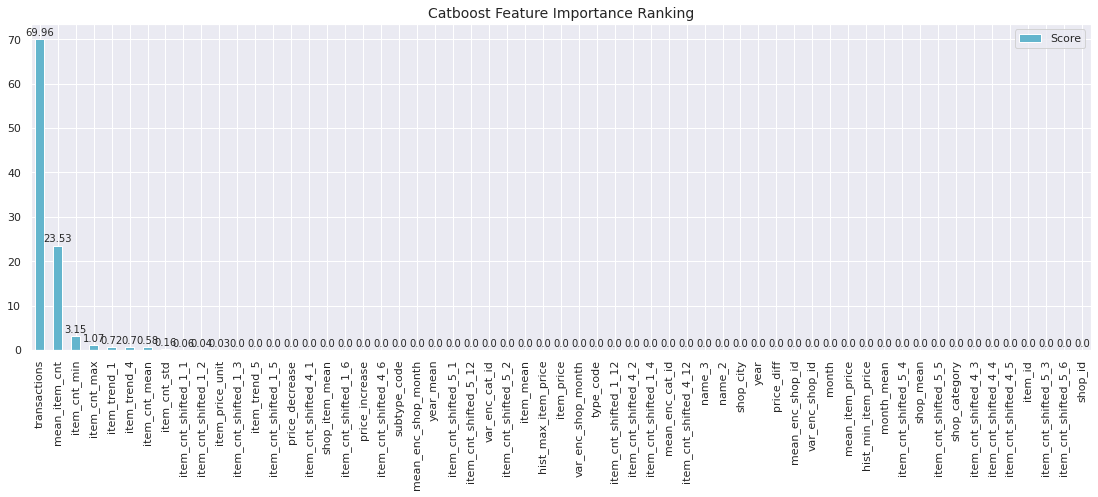

In [141]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, catboost_model.get_feature_importance(Pool(X_train, label=Y_train, cat_features=cat_features)))), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (19, 6)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [149]:
X_train.columns[catboost_model.get_feature_importance() > 0.00001]

Index(['item_price', 'mean_item_cnt', 'transactions', 'item_price_unit',
       'hist_max_item_price', 'price_increase', 'price_decrease',
       'item_cnt_shifted_1_1', 'item_cnt_shifted_1_2', 'item_cnt_shifted_1_3',
       'item_cnt_shifted_1_4', 'item_cnt_shifted_1_5', 'item_cnt_shifted_1_6',
       'item_cnt_shifted_1_12', 'item_cnt_shifted_4_1', 'item_cnt_shifted_4_2',
       'item_cnt_shifted_4_6', 'item_cnt_shifted_5_1', 'item_cnt_shifted_5_2',
       'item_cnt_shifted_5_12', 'item_trend_1', 'item_trend_4', 'item_trend_5',
       'item_cnt_min', 'item_cnt_max', 'item_cnt_mean', 'item_cnt_std',
       'type_code', 'subtype_code', 'item_mean', 'shop_item_mean', 'year_mean',
       'mean_enc_cat_id', 'var_enc_cat_id', 'mean_enc_shop_month',
       'var_enc_shop_month'],
      dtype='object')

### Catboost predict

In [0]:
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_validation)
catboost_test_pred = catboost_model.predict(X_test)

In [144]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, catboost_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, catboost_val_pred)))

Train rmse: 0.014554694760277364
Validation rmse: 0.015281372520498614


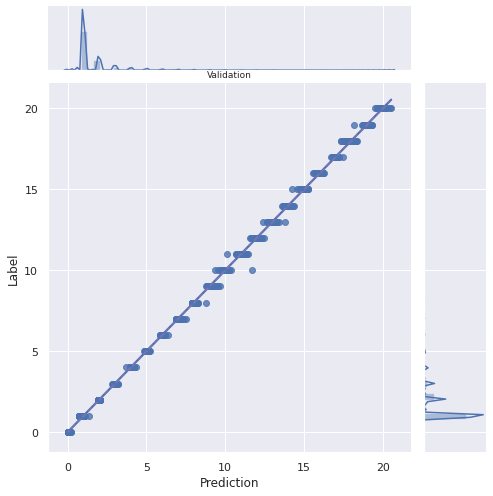

In [145]:
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=7)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()
    
#model_performance_sc_plot(catboost_train_pred, Y_train, 'Train')
model_performance_sc_plot(catboost_val_pred, Y_validation, 'Validation')

### XGBoost

In [0]:
# Use only part of features on XGBoost.
# xgb_features = ['item_cnt','item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
#                 'item_cnt_shifted2', 'item_cnt_shifted3', 'shop_mean', 
#                 'shop_item_mean', 'mean_item_cnt', 'item_trend']

xgb_features = ['mean_item_cnt', 'transactions', 'item_price_unit', 'price_decrease',
       'item_cnt_shifted_1_1', 'item_cnt_shifted_1_2', 'item_cnt_shifted_1_3',
       'item_cnt_shifted_1_5', 'item_cnt_shifted_4_1', 'item_trend_1',
       'item_trend_4', 'item_trend_5', 'item_cnt_min', 'item_cnt_max',
       'item_cnt_mean', 'item_cnt_std', 'shop_item_mean']
                
xgb_train = X_train#[xgb_features]
xgb_val = X_validation#[xgb_features]
xgb_test = X_test#[xgb_features]

In [0]:
xgb_model = XGBRegressor()

In [0]:
params = {'max_depth':[3, 5, 6,7, 8, 9, 10],
          'n_estimators':[250,100,500],
          'min_child_weight':[250,100,500,1000], 
          'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9],
          "subsample":[0.5, 0.6, 0.7, 0.8, 0.9],
          'eta': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
          }

grid = RandomizedSearchCV(estimator=xgb_model, param_distributions=params, cv=2, n_jobs=-1, n_iter=100)
grid.fit(xgb_val, Y_validation)

[15:25:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                               

In [0]:
grid.best_params_

{'colsample_bytree': 0.5,
 'eta': 0.2,
 'max_depth': 8,
 'min_child_weight': 250,
 'n_estimators': 100,
 'subsample': 0.5}

In [0]:
del grid
gc.collect()

3640

In [0]:
best_param_xgb = \
{'colsample_bytree': 0.5,
 'eta': 0.2,
 'max_depth': 8,
 #'min_child_weight': 250,
 'n_estimators': 250,
 'subsample': 0.5
 }

In [198]:
xgb_model = XGBRegressor(**best_param_xgb)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)

[18:20:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.27037	validation_1-rmse:1.98557
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:0.33032	validation_1-rmse:0.297618
[40]	validation_0-rmse:0.090911	validation_1-rmse:0.091603
[60]	validation_0-rmse:0.066215	validation_1-rmse:0.070497
[80]	validation_0-rmse:0.057318	validation_1-rmse:0.063128
[100]	validation_0-rmse:0.051929	validation_1-rmse:0.059005
[120]	validation_0-rmse:0.048482	validation_1-rmse:0.056525
[140]	validation_0-rmse:0.04581	validation_1-rmse:0.054848
[160]	validation_0-rmse:0.043777	validation_1-rmse:0.053578
[180]	validation_0-rmse:0.042006	validation_1-rmse:0.052567
[200]	validation_0-rmse:0.040379	validation_1-rmse:0.051486
[220]	validation_0-rmse:0.039085	validation_1-rmse:0.050845
[240

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, eta=0.2, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=250,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.5, verbosity=1)

### XGBoost feature importance

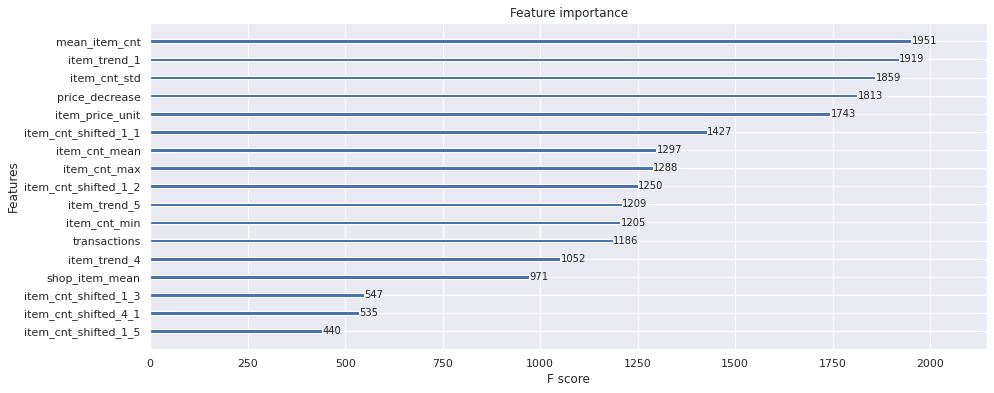

In [155]:
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()

In [0]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [157]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, xgb_val_pred)))

Train rmse: 0.07451077238679288
Validation rmse: 0.08892664492470623


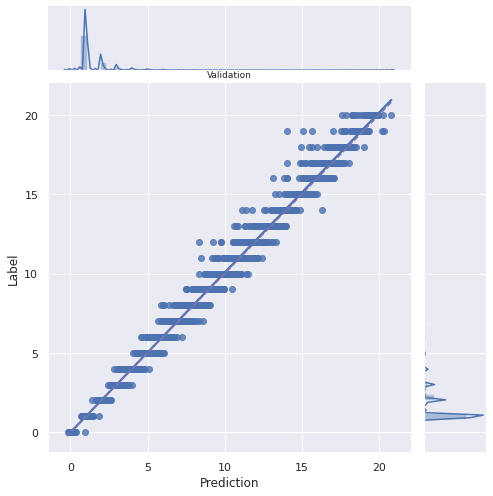

In [158]:
# model_performance_sc_plot(xgb_train_pred, Y_train, 'Train')
model_performance_sc_plot(xgb_val_pred, Y_validation, 'Validation')

### Random Forest

In [0]:
# Use only part of features on random forest.
rf_features = ['shop_id', 'item_id', 'transactions', 'year',
               'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted_1_1', 'item_cnt_shifted_1_3', 
               'shop_mean', 'item_mean', 'mean_item_cnt', 'item_trend_1']

rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

In [0]:
rf_model = RandomForestRegressor()

In [0]:
params = {"n_estimators": [50, 100, 250],
              "max_depth": [3, 5, 7, 10],
              "min_samples_split": [2, 5, 10, 15, 20],
              "min_samples_leaf": [5, 10, 15, 20],
              "max_leaf_nodes": [None, 20, 40]}

grid = RandomizedSearchCV(estimator=rf_model, param_distributions=params, cv=2, n_jobs=-1, n_iter=100)
grid.fit(rf_val, Y_validation)

RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [0]:
grid.best_params_

{'max_depth': 7,
 'max_leaf_nodes': None,
 'min_samples_leaf': 20,
 'min_samples_split': 20,
 'n_estimators': 50}

In [0]:
del grid
gc.collect()

38872

In [168]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [0]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

In [170]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))

Train rmse: 0.06181357402517945
Validation rmse: 0.05779118833192798


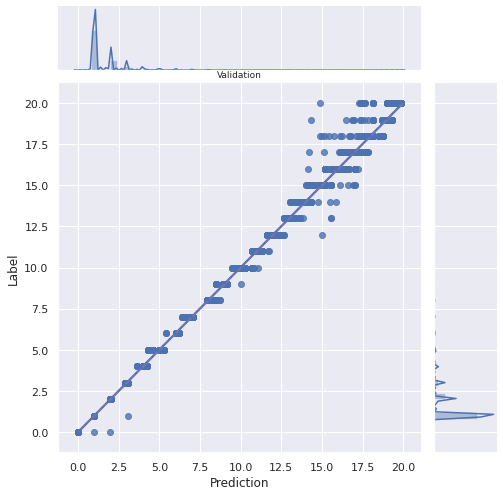

In [171]:
# model_performance_sc_plot(rf_train_pred, Y_train, 'Train')
model_performance_sc_plot(rf_val_pred, Y_validation, 'Validation')

### Linear Regression

In [0]:
X_train.columns

Index(['shop_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt',
       'mean_item_cnt', 'transactions', 'year', 'month', 'item_price_unit',
       'hist_min_item_price', 'hist_max_item_price', 'price_increase',
       'price_decrease', 'price_diff', 'holiday_ft', 'item_cnt_min',
       'item_cnt_max', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted_1_1',
       'item_cnt_shifted_1_2', 'item_cnt_shifted_1_3', 'item_cnt_shifted_1_4',
       'item_cnt_shifted_1_6', 'item_cnt_shifted_1_12', 'item_cnt_shifted_2_1',
       'item_cnt_shifted_2_2', 'item_cnt_shifted_2_3', 'item_cnt_shifted_2_4',
       'item_cnt_shifted_2_6', 'item_cnt_shifted_2_12', 'item_trend_1',
       'item_trend_2', 'shop_city', 'shop_category', 'type_code',
       'subtype_code', 'name_2', 'name_3', 'hist_min_shop_revenue',
       'hist_max_shop_revenue', 'hist_mean_shop_revenue',
       'hist_min_shop_revenue_month', 'hist_max_shop_revenue_month',
       'hist_mean_shop_revenue_month', 'hist_min_category_r

In [0]:
# Use only part of features on linear Regression.
# add item_trend
lr_features = ['mean_item_cnt', 'shop_mean', 'item_cnt_shifted_1_2', 'item_cnt_shifted_1_3', 'item_cnt_shifted_1_4',
       'item_cnt_shifted_1_6', 'item_cnt_shifted_1_12', 'item_trend_1']#, 'item_cnt_shifted2', 'item_cnt_shifted12', 'item_trend', 'shop_item_mean', 'month_mean']

lr_train = X_train[lr_features]
lr_val = X_validation[lr_features]
lr_test = X_test[lr_features]

#### Normalizing features

In [0]:
lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

#### Fitting LR model

In [176]:
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [0]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)

In [178]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, lr_val_pred)))

Train rmse: 1.6152916028739874
Validation rmse: 1.449797246650624


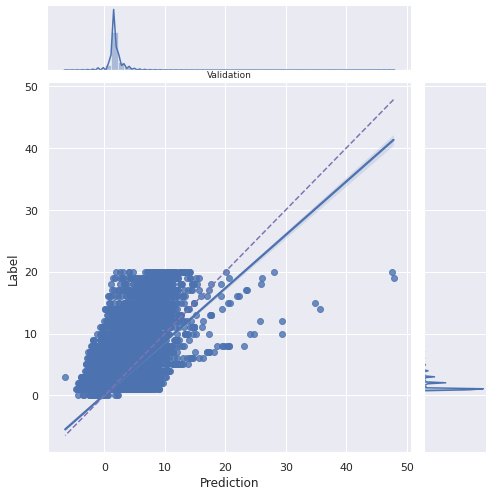

In [179]:
# model_performance_sc_plot(lr_train_pred, Y_train, 'Train')
model_performance_sc_plot(lr_val_pred, Y_validation, 'Validation')

### KNN Regressor

In [0]:
# Use only part of features on KNN.
knn_features = ['mean_item_cnt', 'shop_mean', 'item_cnt_shifted_1_2', 'item_cnt_shifted_1_3', 'item_cnt_shifted_1_4',
       'item_cnt_shifted_1_6', 'item_cnt_shifted_1_12', 'item_trend_1']

# Subsample train set (using the whole data was taking too long).
X_train_sampled = X_train[:100000]
Y_train_sampled = Y_train[:100000]

knn_train = X_train_sampled[knn_features]
knn_val = X_validation[knn_features]
knn_test = X_test[knn_features]

#### Normalizing features

In [0]:
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)

In [182]:
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train_sampled)

KNeighborsRegressor(algorithm='auto', leaf_size=13, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                    weights='uniform')

In [0]:
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)

In [184]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_sampled, knn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, knn_val_pred)))

Train rmse: 1.36966572474121
Validation rmse: 1.2019769119417245


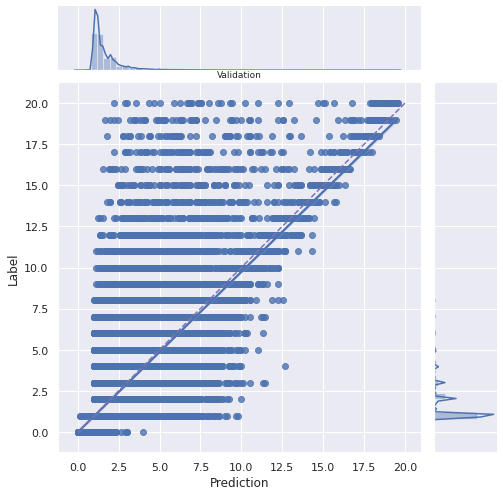

In [185]:
# model_performance_sc_plot(knn_train_pred, Y_train_sampled, 'Train')
model_performance_sc_plot(knn_val_pred, Y_validation, 'Validation')

### Creating first level model

In [186]:
# Dataset that will be the train set of the ensemble model.
first_level = pd.DataFrame(catboost_val_pred, columns=['catboost'])
first_level['xgbm'] = xgb_val_pred
first_level['random_forest'] = rf_val_pred
first_level['linear_regression'] = lr_val_pred
first_level['knn'] = knn_val_pred
first_level['label'] = Y_validation.values
first_level.head()

,catboost,xgbm,random_forest,linear_regression,knn,label
0,1.00,1.00,1.00,2.04,1.67,1
1,1.00,1.00,1.00,1.32,1.00,1
2,1.00,1.00,1.00,2.14,2.00,1
3,2.00,2.00,2.00,4.61,1.67,2
4,1.00,0.99,1.00,0.47,1.44,1


In [187]:
# Dataset that will be the test set of the ensemble model.
first_level_test = pd.DataFrame(catboost_test_pred, columns=['catboost'])
first_level_test['xgbm'] = xgb_test_pred
first_level_test['random_forest'] = rf_test_pred
first_level_test['linear_regression'] = lr_test_pred
first_level_test['knn'] = knn_test_pred
first_level_test.head()

,catboost,xgbm,random_forest,linear_regression,knn
0,1.00,1.03,1.00,0.76,1.78
1,1.00,1.00,1.00,1.07,1.00
2,3.00,2.89,3.00,2.44,2.44
3,1.00,1.00,1.00,1.43,1.00
4,1.00,1.00,1.00,1.07,1.00


## Second level model

In [0]:
meta_model = LinearRegression(n_jobs=-1)

In [189]:
# Drop label from dataset.
first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, Y_validation)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [0]:
# Make predictions on test set using the 1st level models predictions as features
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)

In [191]:
# Ensemble model metrics on validation set
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_pred, Y_validation)))

Train rmse: 0.014540567692900274


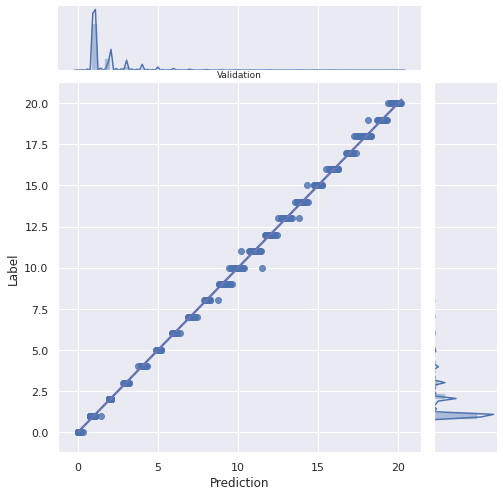

In [192]:
model_performance_sc_plot(ensemble_pred, Y_validation, 'Validation')

# Output

In [193]:
prediction_df = pd.DataFrame(test_df['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)
prediction_df.to_csv('submission.csv', index=False)
prediction_df.head(10)

,ID,item_cnt_month
0,0,1.00
1,1,1.00
2,2,3.00
3,3,1.00
4,4,1.00
5,5,1.00
6,6,3.00
7,7,1.00
8,8,3.00
9,9,1.00
